In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift

In [2]:


def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        print('Spectrum file missing...')
        return
    return lam,flux,fluxsig

def adapted_ch_cont(array,continuum,sigarray = None):
    spec = array
    notnan = ~np.isnan(spec)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum*notnan],spec[continuum*notnan],10)
    cont = np.polynomial.chebyshev.chebval(lamgrid,p)
    contcorr = spec / cont
    if sigarray is not None:
        stdev = np.sqrt(1.0/sigarray)
        contsigarray = stdev / cont
        normivar = (1.0/contsigarray)**2
        return contcorr,normivar
    return contcorr

def norm_dataspec(array,sigarray=None):
    contcorr,contsig = adapted_ch_cont(array,continuum,sigarray)
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    #contcorr[where] = 1
    return contcorr,contsig


## Model

In [3]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


In [4]:
sc = MinMaxScaler()
msc = StandardScaler()

In [40]:
## Load Model Spectra

searchparameter = '_'

prefilenames = os.listdir('koester2/')
filenames = []
for i in range(len(prefilenames)):
    if searchparameter in prefilenames[i]:
        filenames.append(prefilenames[i])
        
len(filenames)

modelspectra = [];
modelwl = [];
loggs = [];
teffs = [];
for i in (filenames):
    specname=i
    f = open('koester2/'+specname)
    data = f.readlines()
    f.close()
    headerdata = data[0:7]
    spectraldata = data[6:]
    lam = []
    flux = []

    for i in range(len(spectraldata)):
        l=float(spectraldata[i].split()[0])
        lam.append(l)
        f = float(spectraldata[i].split()[1])
        flux.append(f)

    lam = np.asarray(lam)
    flux = np.asarray(flux) / 1e7

    teff = float(headerdata[1].split()[3])
    logg = float(headerdata[2].split()[3])
    
    in1 = find_nearest(lam,4000)
    in2 = find_nearest(lam,8000)

    flux = flux[in1:in2]
    lam = lam[in1:in2]
    
    flux = flux[:-1][~ (np.diff(lam) == 0)]
    lam = lam[:-1][~ (np.diff(lam) == 0)]
    
    lamgrid = np.arange(4000,8000)
    
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    modelspectra.append(flux)
    modelwl.append(lam)
    teffs.append(teff)
    loggs.append(logg)

modelspectra = np.asarray(modelspectra)
loggs = np.asarray(loggs)
teffs = np.asarray(teffs)

In [43]:
pickle.dump(norm_modelspectra,open('koester_models.p','wb'))
pickle.dump(loggs, open('loggs.p','wb'))
pickle.dump(teffs, open('teffs.p','wb'))

In [42]:
pixels = np.arange(0,4000)
continuum = (pixels > 2900) + (pixels < 2200)*(pixels > 1200) + (pixels < 650)*(pixels > 530) \
            + (pixels < 35)*(pixels > 20) + (pixels < 220)*(pixels > 200)

norm_modelspectra = [adapted_ch_cont(i,continuum) for i in modelspectra]
norm_modelspectra = np.asarray(norm_modelspectra)

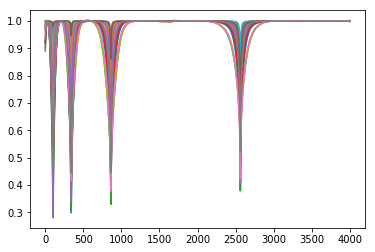

In [7]:
plt.plot(norm_modelspectra[2:20].T);

In [17]:
X = np.stack((teffs,loggs)).T
t = norm_modelspectra

X_scaled = sc.fit_transform(X)
t_scaled = msc.fit_transform(t)

In [18]:
X_scaled.shape

(1040, 2)

In [19]:
X_scaled.shape

(1040, 2)

In [20]:
def vloss(ypred,ytrue):
    resid = ypred-ytrue
    return K.mean(K.exp(resid**2))

In [21]:
K.set_image_dim_ordering('tf')

In [22]:
H = 32
reg = 0.0001
def generator():
    x = Input(shape=(2,))
    y = Dense(H,activation='sigmoid',trainable = True)(x)
    y = Dense(H,activation='sigmoid',trainable = True)(y)
    out = Dense(4000,activation='linear',trainable = True)(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('normNN.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 4000)              132000    
Total params: 133,152
Trainable params: 133,152
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
for i in tqdm(range(10)): 
    print('Training meta-batch %i'%i)
    
    n_epochs = 1000
    batch = 1040
    
    
    h = model.fit(X_scaled,t_scaled, epochs = n_epochs, verbose = 1, batch_size = batch, shuffle = True)
    history = np.append(history, h.history['loss'])
    #model.save_weights('normNN_conv.h5')

  0%|          | 0/10 [00:00<?, ?it/s]

Training meta-batch 0
Epoch 1/1000
1040/1040 [==============================] - 0s 271us/step - loss: 0.0212 - mean_absolute_error: 0.0660
Epoch 2/1000
1040/1040 [==============================] - 0s 65us/step - loss: 0.0236 - mean_absolute_error: 0.0773
Epoch 3/1000
1040/1040 [==============================] - 0s 62us/step - loss: 0.0216 - mean_absolute_error: 0.0680
Epoch 4/1000
1040/1040 [==============================] - 0s 60us/step - loss: 0.0214 - mean_absolute_error: 0.0685
Epoch 5/1000
1040/1040 [==============================] - 0s 59us/step - loss: 0.0219 - mean_absolute_error: 0.0713
Epoch 6/1000
1040/1040 [==============================] - 0s 64us/step - loss: 0.0220 - mean_absolute_error: 0.0713
Epoch 7/1000
1040/1040 [==============================] - 0s 60us/step - loss: 0.0218 - mean_absolute_error: 0.0694
Epoch 8/1000
1040/1040 [==============================] - 0s 62us/step - loss: 0.0215 - mean_absolute_error: 0.0676
Epoch 9/1000
1040/1040 [=========================

KeyboardInterrupt: 

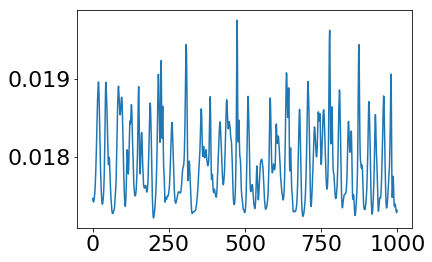

In [162]:
plt.plot(history[-1000:])

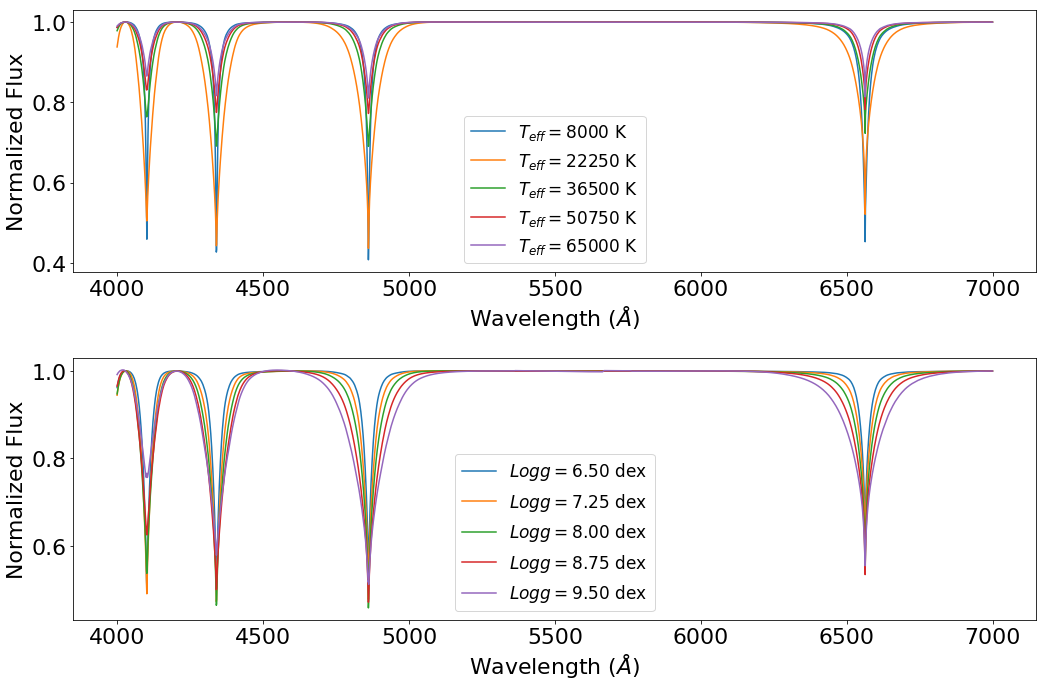

In [44]:
plt.figure(figsize=(15,10))

low = 0
high = 3000

plt.subplot(211)
ts = np.linspace(8000,65000,5)
ls = np.linspace(8,8,5)
plt.rcParams.update({'font.size': 22})             
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[low:high],adapted_ch_cont(gens[i],continuum)[low:high],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.subplot(212)
ts = np.linspace(25000,25000,5)
ls = np.linspace(6.5,9.5,5)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[low:high],adapted_ch_cont(gens[i],continuum)[low:high],label='$Logg = %.2f$ dex'%ls[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')
plt.tight_layout()

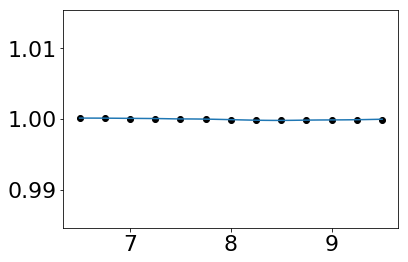

In [63]:
pixel = int(hbeta)-4000+3100

temp = 14000


ts = teffs[teffs == temp]
ls = loggs[teffs == temp]
labels = np.stack((ts,ls)).T
tflux = (t)[teffs == temp][:,pixel]

plt.scatter(ls,tflux,color='k')

linls = np.linspace(min(ls),max(ls),100)
lints = np.repeat(temp,100)
linlabels = np.stack((lints,linls)).T
lintflux = (msc.inverse_transform(model.predict(sc.transform(linlabels))))[:,pixel]
plt.plot(linls,lintflux)

## SDSS Data

In [166]:
filetable = Table.read('filetable.fits')
wdtable = Table.read('tremblay_final.fits')
print(len(wdtable))
wdtable = join(filetable,wdtable,keys = ['source_id','Teff','log_g','spectral_class','S/N'])

DA = (wdtable['spectral_class'] == 'DA')*(~np.isnan(wdtable['Teff']))*(~np.isnan(wdtable['log_g']))*\
        (wdtable['S/N'] > 55)*(wdtable['spec_Teff'] < 80000)
wdtable = wdtable[DA]
print(len(wdtable))
wdtable = wdtable[np.random.randint(0,len(wdtable),len(wdtable))]

5396
105


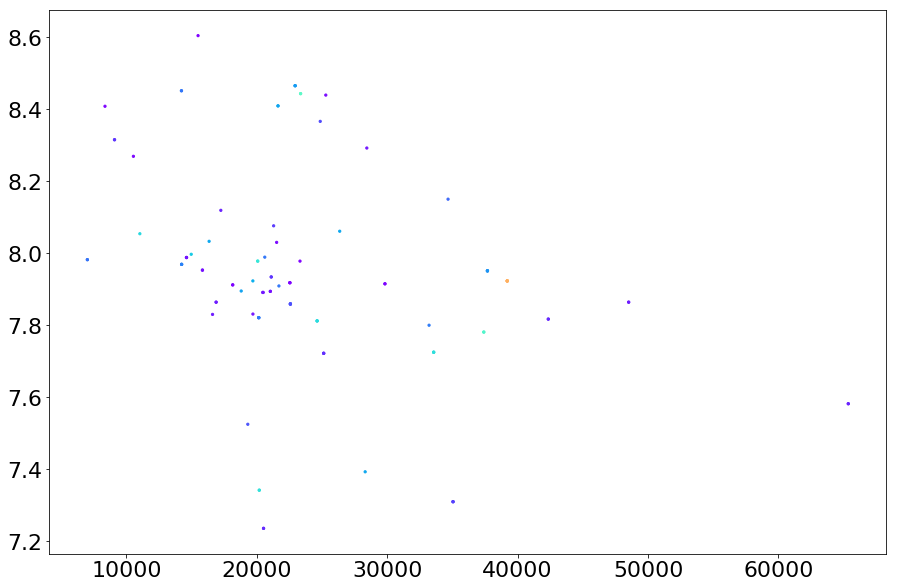

In [167]:
plt.scatter(wdtable['spec_Teff'],wdtable['spec_logg'], s = 5, c = wdtable['S/N'], vmax = 100, cmap = 'rainbow')

In [168]:
interpfluxs = [];
sigs = [];
lamgrid = np.arange(4000,8000)
for i in tqdm(range(len(wdtable))):
    spec = get_spectrum(wdtable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    sig = spec[2]
    func2 = interp1d(lam,sig,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpsig = func2(lamgrid)
    #trans = ((wdtable['center_b'][i] - hbeta)+(wdtable['center_a'][i]-halpha))/2
    #shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)
    sigs.append(interpsig)


100%|██████████| 105/105 [00:08<00:00, 12.26it/s]

In [169]:
spectra = np.asarray(interpfluxs)
sigs = np.asarray(sigs)
lamgrid = np.arange(4000,8000)

CPU times: user 53.6 ms, sys: 2.64 ms, total: 56.3 ms
Wall time: 15.7 ms


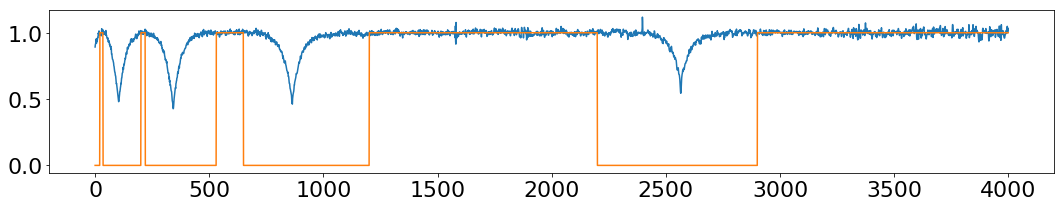

In [170]:
%%time
plt.figure(figsize=(18,3))
plt.plot(adapted_ch_cont(spectra[24],continuum))
plt.plot(continuum)

In [171]:
wdtable['spectrum'] = spectra
wdtable['ivar'] = sigs

In [172]:
clamgrid = np.linspace(4000,7000,3000)

In [173]:
norms = [norm_dataspec(np.asarray(wdtable['spectrum'][ii]),np.asarray(wdtable['ivar'][ii])) for ii in range(len(wdtable))]
wdtable['normspectrum'] = np.asarray(norms)[:,0]
wdtable['normivar'] = np.asarray(norms)[:,0]

# Fitting

In [182]:
lines = ((lamgrid > hbeta-200) & (lamgrid < hbeta + 300)) | ((lamgrid > halpha-250) & (lamgrid < halpha + 300))\
        | ((lamgrid > hgamma-120) & (lamgrid < hgamma + 400))| ((lamgrid > hdelta-90) & (lamgrid < hdelta + 150))
def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    synth = dopplerShift(wl,np.ravel(
                        msc.inverse_transform(
                                model.predict(label))[0]
                        ), trans*1000
                    )[0]
    return (np.ravel(synth).astype('float64'))

def norm_spectrum_sampler(wl,teff,logg,trans):
    synth = spectrum_sampler(lamgrid,teff,logg,trans)
    return synth[lines]

def chisquare(residual):
    return sum(residual**2)

def get_prior_teff(array):
    spec = np.asarray(array)
    priorfitter = lmfit.Model(spectrum_sampler)
    priorparams = priorfitter.make_params()
    priorparams['logg'].set(value = 8., vary = False)
    priorparams['teff'].set(value = 10000,min = 5500, max = 80000)
    priorparams['trans'].set(value = 0., vary = False)
    priorfitter.eval(priorparams, wl = lamgrid)
    prior_result = priorfitter.fit(spec, priorparams, wl = lamgrid, method = 'Powell', nan_policy = 'omit');
    #print(prior_result.fit_report())
    return prior_result.params['teff'].value

def get_posteriors(array, n_eval = 3000):
    spec = array
    normspec = adapted_ch_cont(spec,continuum)
    def chisq(params):
        teff,logg,trans = params
        res = normspec[lines] - norm_spectrum_sampler(lamgrid,teff,logg,trans)
        res = res[~np.isnan(res)]
        chisq = np.sum(res**2)
        return chisq
    teff_init = get_prior_teff(spec)
   # p = scipy.optimize.minimize(chisq, bounds = [(5500,80000),(6.5,9.5),(-3,3)], x0 = [teff_init, 8., 0],\
                             #  method = 'dual_annealing')
    p = scipy.optimize.dual_annealing(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],maxfun = n_eval,\
                                      x0 = [teff_init, 8., 0])
    #p = scipy.optimize.differential_evolution(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],\
       #                              disp = True)
    
#     plt.plot(normspec[lines])
#     plt.plot(norm_spectrum_sampler(lamgrid,p.x[0],p.x[1],p.x[2]))
    return p.x

#### Evaluate NFev

### Evaluate on Synthetics

### Test on Model Spectra

### Fit SDSS

### MCMC Fitting

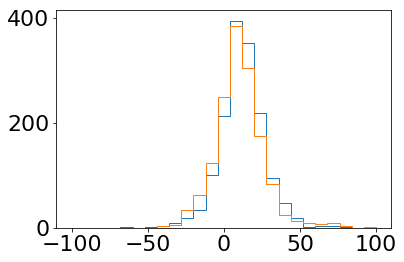

In [59]:
plt.hist(1e5*(wdtable['centre_beta']-hbeta)/hbeta, range = (-100,100), histtype = 'step', bins = 25);
plt.hist(1e5*(wdtable['centre_alpha']-halpha)/halpha, range = (-100,100), histtype = 'step', bins = 25);

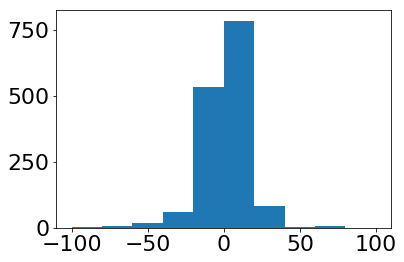

In [60]:
plt.hist((1e5*(wdtable['centre_beta']-hbeta)/hbeta) - (1e5*(wdtable['centre_alpha']-halpha)/halpha), range = (-100,100));

In [61]:
50e-5 * hbeta

2.43134

In [32]:
%%timeit

norm_spectrum_sampler(lamgrid,15000,8.,0)

1.56 ms ± 93.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
%%timeit 

spectrum_sampler(lamgrid,15000,8.,0)

901 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
%%timeit

msc.inverse_transform(model.predict(sc.transform(np.asarray([15000,8]).reshape(-1,1).T)))

375 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [180]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

Finding MLE Point...
Restarting MCMC around MLE...


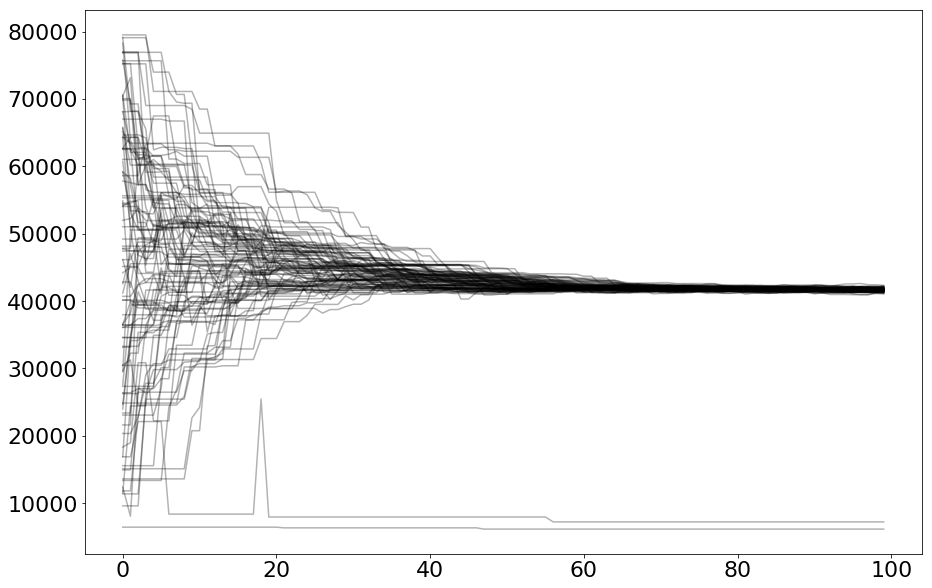

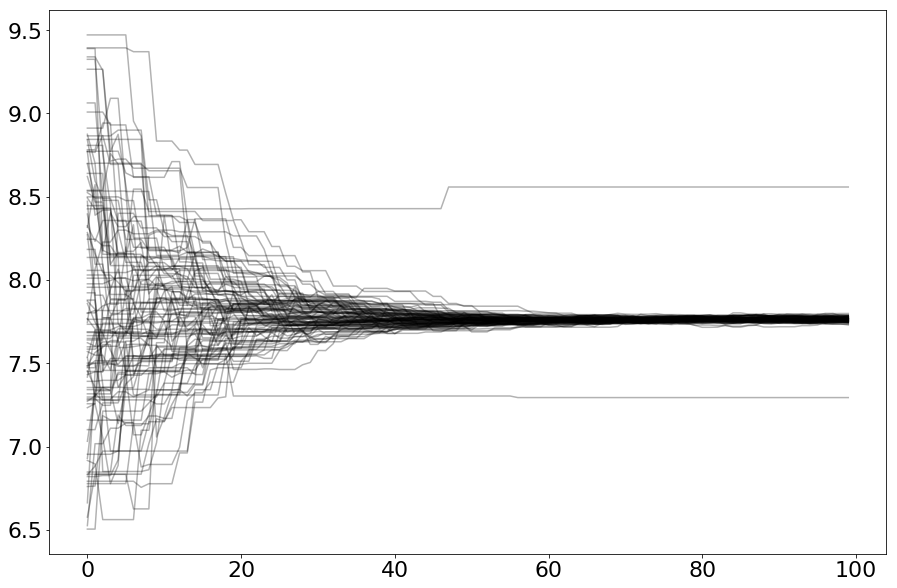

Burning in 25 samples... (0 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burn-in terminated with correlation fraction = 0.13
Sampling 100 draws from posterior


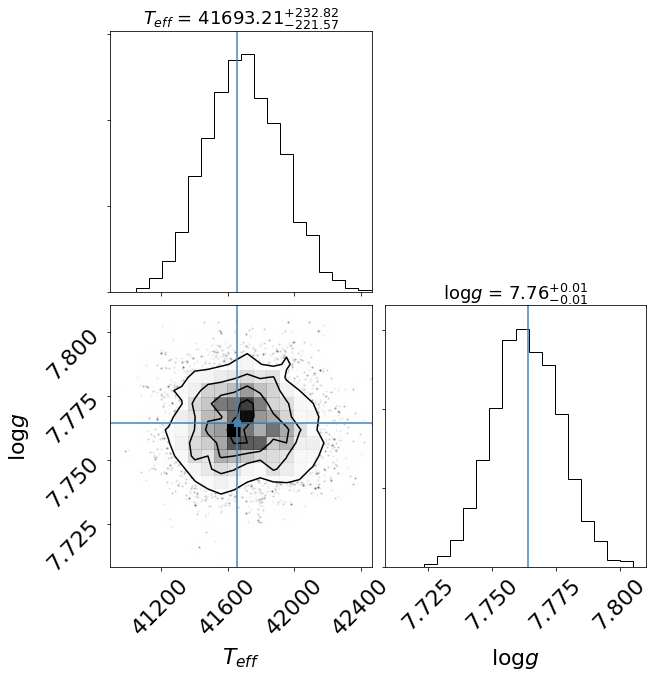

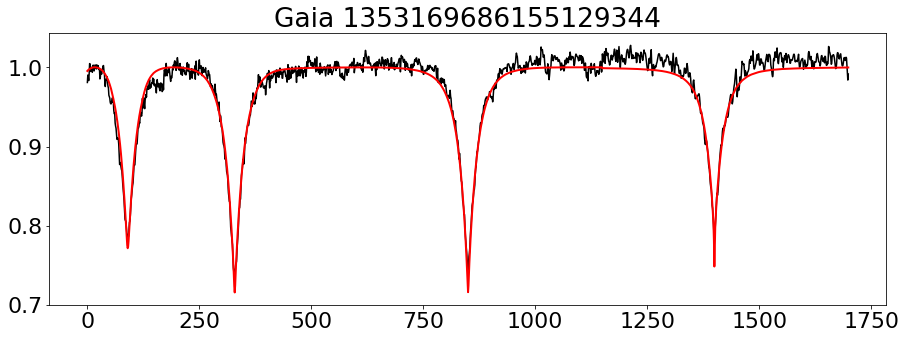


100%|██████████| 1/1 [00:42<00:00, 42.66s/it]

In [184]:
results = [];
for ii in tqdm(range(len(wdtable[0:1]))):
    
    spec = wdtable['spectrum'][ii]
    sig = wdtable['ivar'][ii]
    normspec,normsig = norm_dataspec(spec,sig)
    normspec = normspec[lines]
    normsig = normsig[lines]
    teff_prior = get_prior_teff(spec)
    def lnlike(prms):
        ivar = normsig
        model = spectrum_sampler(lamgrid,prms[0],prms[1],prms[2])[lines]
        diff = model - normspec
        diff = diff[~np.isnan(model)]
        ivar = ivar[~np.isnan(model)]
        chisq = np.sum(diff**2 * ivar)
        lnlike = -0.5 * chisq
    #     plt.plot(model)
    #     plt.plot(normspec)
        return lnlike

    def lnprior(prms):
        if prms[0] < 6000 or prms[0] > 80000:
            return -np.Inf
        elif prms[1] < 6.5 or prms[1] > 9.5:
            return -np.Inf
        elif prms[2] < -3 or prms[2] > 3:
            return -np.Inf

        mu = teff_prior
        sigma = 5000
        return 0#np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(prms[0]-mu)**2/sigma**2

    def lnprob(prms):
        lp = lnprior(prms)
        if not np.isfinite(lp):
            return -np.Inf
        return lp + lnlike(prms)


    ndim,nwalkers = 3,100


    steps = 100
    burn_step = 25
    total_burned = 0
    
    nll = lambda *args: -lnlike(*args)
    #p0 = np.asarray(get_posteriors(spec))
    #p0 = p.x
    pos0 = np.zeros((nwalkers,ndim))
    
    lows = [5500,6.5,-3]
    highs = [80000,9.5,3]
    
    for jj in range(ndim):
        pos0[:,jj] = ( np.random.uniform(lows[jj], highs[jj], nwalkers) )
        
        

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,threads = 1)
    
    acorrtime = 1e5
    #Initialize sampler
    print('Finding MLE Point...')
    b = sampler.run_mcmc(pos0,100)
    print('Restarting MCMC around MLE...')
    
    plt.plot(sampler.chain[:,:,0].T, alpha = 0.3, color = 'k');
    plt.figure()
    plt.plot(sampler.chain[:,:,1].T, alpha = 0.3, color = 'k');
    plt.show()
    
    mlpt = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    pos1 = np.zeros((nwalkers,ndim))
    
    for jj in range(ndim):
        pos1[:,jj] = (mlpt[jj] + 0.01 * mlpt[jj] * np.random.randn(nwalkers))
    
    b = sampler.run_mcmc(pos1,1) #Initialize
    
    while acorrtime > (0.25 * total_burned):
        print('Burning in %i samples... (%i done)'%(burn_step,total_burned))
        b = sampler.run_mcmc(b[0],burn_step)
        total_burned = total_burned + burn_step
        try:
            acorr_teff = emcee.autocorr.function(sampler.chain[0][:,0])
            acorrtime_teff = np.argmax(acorr_teff < (1/np.exp(1)))
            acorr_logg = emcee.autocorr.function(sampler.chain[0][:,1])
            acorrtime_logg = np.argmax(acorr_logg < (1/np.exp(1)))
            acorrtime = np.mean([acorrtime_teff, acorrtime_logg])
            print('Autocorr Time = %i samples.'%int(acorrtime))
        except :
            print('Chain too short.')
            continue;
            
        if (total_burned > 1000) and (acorrtime != 1e5):
            print('Maximum burn time reached.')
            break;
    
    print('Burn-in terminated with correlation fraction = %.2f'%(acorrtime/total_burned))
    
    n_draws = np.max([acorrtime, 100]) 
    print('Sampling %i draws from posterior'%n_draws)
    
    sampler.reset()
    s = sampler.run_mcmc(b[0],int(n_draws))
    values = np.median(sampler.flatchain,0)
    meanvalues = np.mean(sampler.flatchain,0)
    modevalues = stats.mode(sampler.flatchain,0)[0]
    mlevalues = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    chi2 = -2*lnlike(mlevalues)
    lower = np.quantile(sampler.flatchain,.3173,axis=0)
    upper = np.quantile(sampler.flatchain,.6827,axis=0)
    std = np.std(sampler.flatchain,axis=0)
    
    results.append([values, meanvalues, modevalues, mlevalues, lower, upper, std, chi2])
    
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    f = corner.corner(sampler.flatchain[:,0:2],show_titles = True,smooth = 0,truths = (mlevalues[0],\
            mlevalues[1]),labels = ('$T_{eff}$','$\log{g}$'),title_kwargs={'fontsize':18}, fig = fig)
    plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_corner.png')

    plt.figure(figsize = (15,5))
    plt.title('Gaia '+str(wdtable[ii]['source_id']))
    plt.plot(normspec,'k', label = 'Data Spectrum')
    plt.plot(norm_spectrum_sampler(lamgrid,mlevalues[0],mlevalues[1],mlevalues[2]),'r',\
             label = 'Fitted Synthetic',linewidth=2)
    #plt.legend()
    plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_fit.png')
    #plt.close()
    plt.show()

In [24]:
results = np.asarray(results)
mles = results[:,3]
lowers = results[:,4]
uppers = results[:,5]
stds = results[:,6]
chi2s = results[:,7]/(4000 - 3)

### Compare to Tremblay

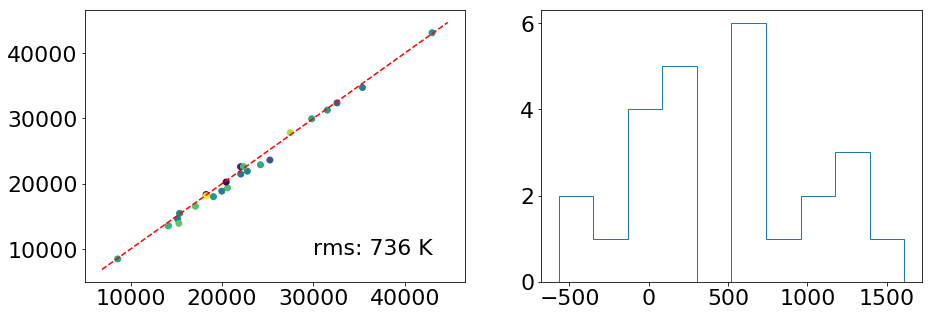

In [25]:
plt.rcParams.update({'font.size': 22})

mlespec_Teff = [i[0] for i in mles]
lowspec_Teff = [i[0] for i in stds]
highspec_Teff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, c = wdtable['log_g'][0:len(mles)])
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

Text(0, 0.5, 'Fitted $T_{eff}$ (K)')

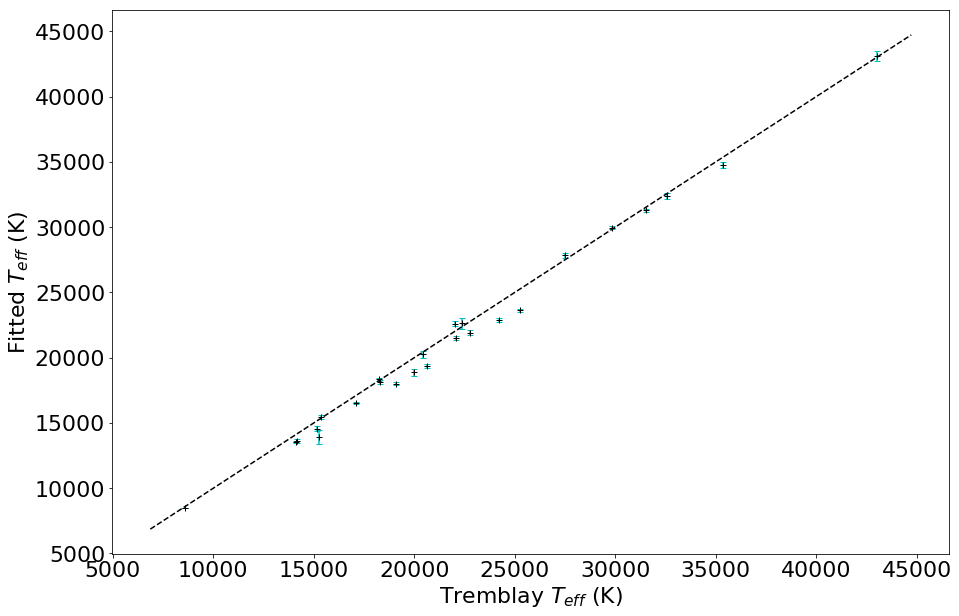

In [26]:
mlespec_Teff = [i[0] for i in mles]
mask = np.asarray(mlespec_Teff) < 25000
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, yerr = (lowspec_Teff,highspec_Teff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

823.8155335857884

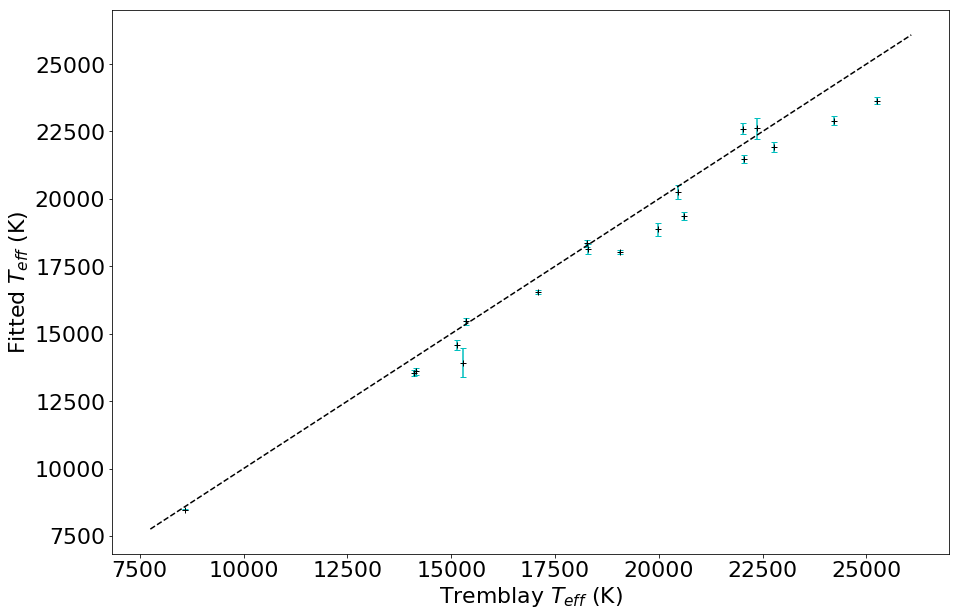

In [27]:
mlespec_Teff = [i[0] for i in mles]
mask = np.asarray(mlespec_Teff) < 25000
resid = wdtable['spec_Teff'][0:len(mles)][mask]-np.asarray(mlespec_Teff)[mask]
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)][mask],np.asarray(mlespec_Teff)[mask], yerr = (np.asarray(lowspec_Teff)[mask],np.asarray(highspec_Teff)[mask]), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')
rms

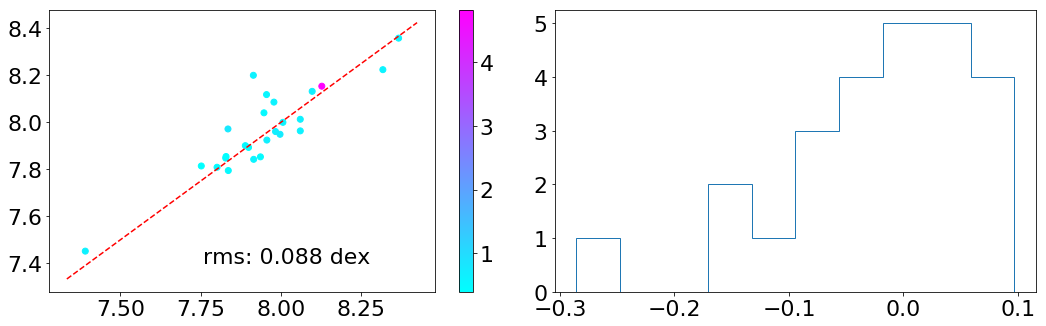

In [28]:
mlespec_logg = [i[1] for i in mles]
lowspec_logg = [i[1] for i in stds]
highspec_logg = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['spec_logg'][0:len(mles)],mlespec_logg, c = chi2s, cmap = 'cool')
plt.colorbar()
plt.text(0.4,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

Text(0, 0.5, 'Fitted $\\log{g}$ (dex)')

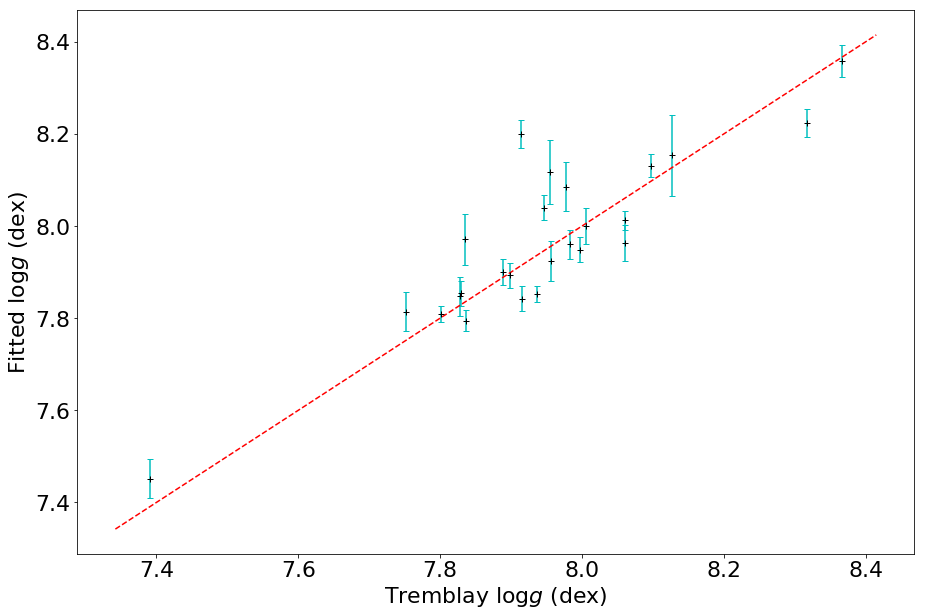

In [29]:
mlespec_logg = [i[1] for i in mles]
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_logg'][0:len(mles)],mlespec_logg, yerr = (lowspec_logg,highspec_logg), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')

In [ ]:
results = pickle.load(open('223wdfits.p','rb')) 

### Compare to Fusilio

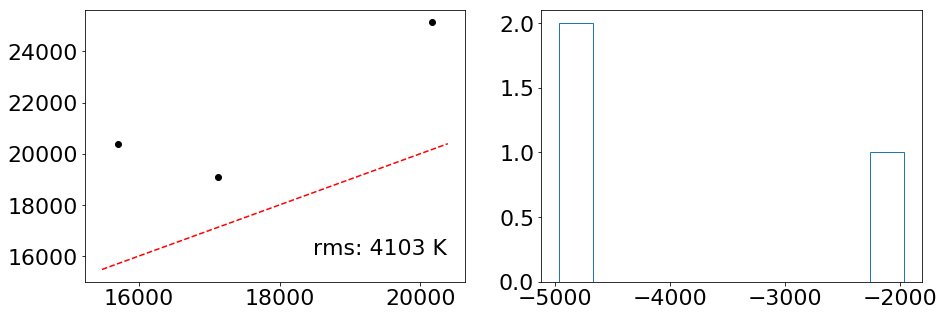

In [107]:
mleteff = [i[0] for i in mles]
lowteff = [i[0] for i in stds]
highteff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['Teff'][0:len(mles)],mleteff, color = 'k')
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

Text(0, 0.5, 'Fitted $T_{eff}$ (K)')

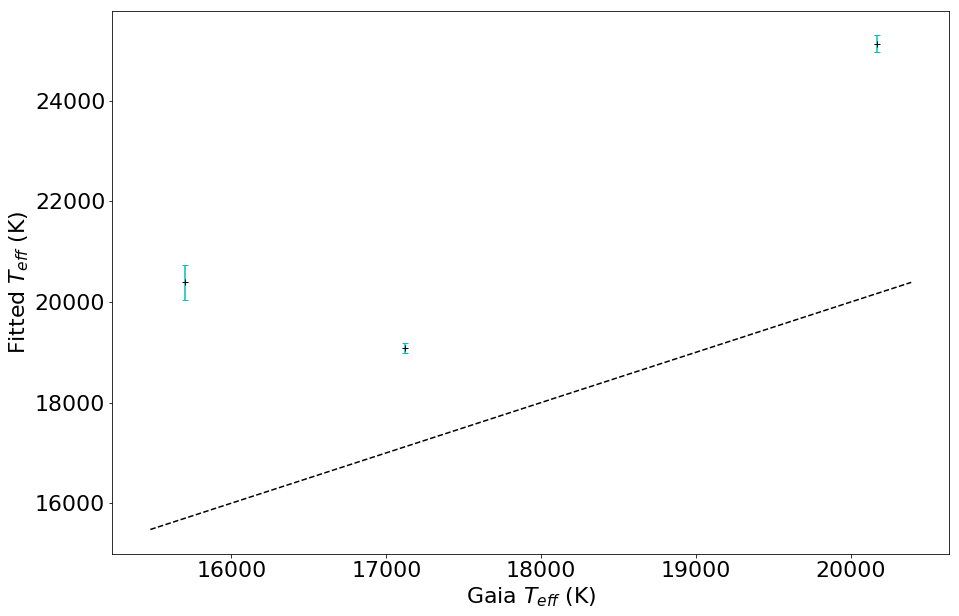

In [108]:
mleteff = [i[0] for i in mles]
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['Teff'][0:len(mles)],mleteff, yerr = (lowteff,highteff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Gaia $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

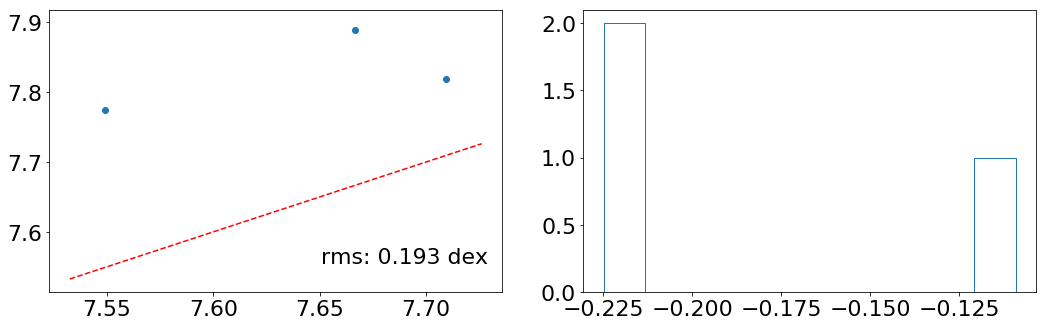

In [109]:
mlelog_g = [i[1] for i in mles]
lowlog_g = [i[1] for i in stds]
highlog_g = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['log_g'][0:len(mles)],mlelog_g)
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

Text(0, 0.5, 'Fitted $\\log{g}$ (dex)')

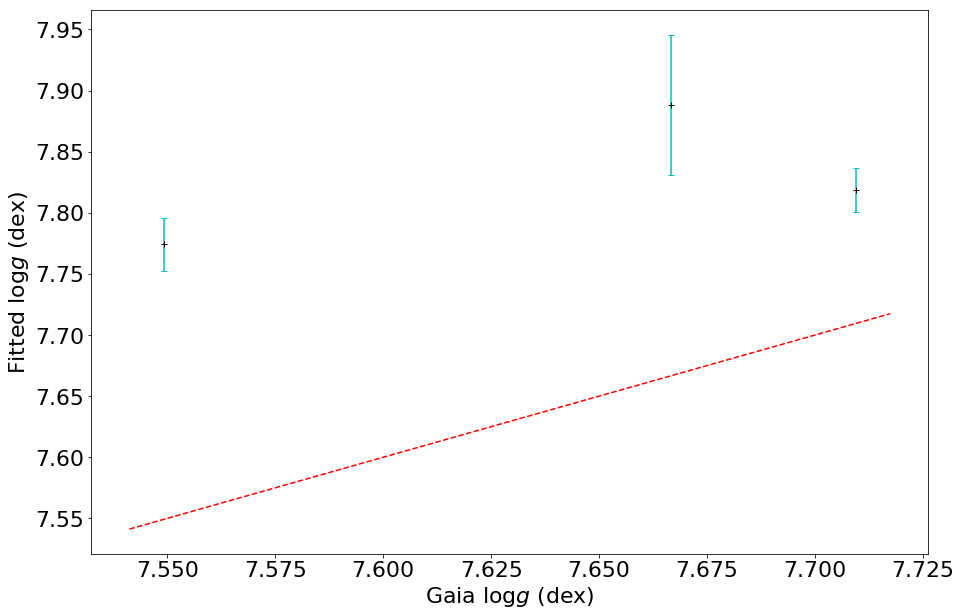

In [110]:
mlelog_g = [i[1] for i in mles]
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['log_g'][0:len(mles)],mlelog_g, yerr = (lowlog_g,highlog_g), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Gaia $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')